**Project - Twitter US Airline Sentiment**

**Background and Context:**

Listening to how customers feel about the product/services on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand, and their competitors, and discover new trends in the industry.

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

**Objective:**

To implement the techniques learned (Text Preprocessing, Data Preparation, Vectorization) as a part of the course.



---
#### 1. Import the libraries, load dataset, the print shape of data, data description. ***(5 Marks)***
---





> ##### Import libraries



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt    
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer    
from sklearn.feature_extraction.text import TfidfVectorizer          
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from mlxtend.plotting import plot_confusion_matrix

import re, string, unicodedata

from bs4 import BeautifulSoup

import nltk

nltk.download("book")
from nltk.tokenize import TweetTokenizer   

from nltk.corpus import stopwords
nltk.download('stopwords')                              

from nltk.stem.wordnet import WordNetLemmatizer        

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

from wordcloud import WordCloud,STOPWORDS

!pip install contractions
import contractions



> ##### Load the dataset 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = '/content/drive/My Drive/GreatLearning/NaturalLanguageProcessing/PROJECT/'
dataset = project_path + 'Tweets.csv'

In [ ]:
df = pd.read_csv(dataset)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)




> ##### Print the shape and description



In [ ]:
#print the shape
df.shape

(14640, 15)

In [ ]:
#print the summary description
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tweet_id,14640,NaN,NaN,NaN,5.69218e+17,7.79111e+14,5.67588e+17,5.68559e+17,5.69478e+17,5.6989e+17,5.70311e+17
airline_sentiment,14640,3,negative,9178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_sentiment_confidence,14640,NaN,NaN,NaN,0.900169,0.16283,0.335,0.6923,1,1,1
negativereason,9178,10,Customer Service Issue,2910,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negativereason_confidence,10522,NaN,NaN,NaN,0.638298,0.33044,0,0.3606,0.6706,1,1
airline,14640,6,United,3822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_sentiment_gold,40,3,negative,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,14640,7701,JetBlueNews,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negativereason_gold,32,13,Customer Service Issue,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retweet_count,14640,NaN,NaN,NaN,0.0826503,0.745778,0,0,0,0,44


```
* The dataset contains 14,640 rows and 15 features.
* There are null values in some of the colums - but for this notebook we are only concerned about the coloumn "text"
```

---
#### 2. Understanding of data columns: ***(5 Marks)***
---





> ##### Exploring the common words before pre-processing



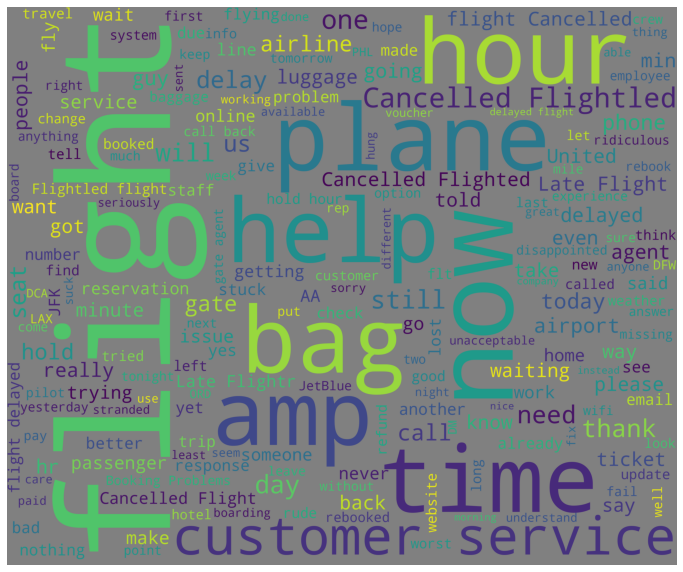

In [ ]:
#wordcloud Negative Sentiment
new_df=df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='gray',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

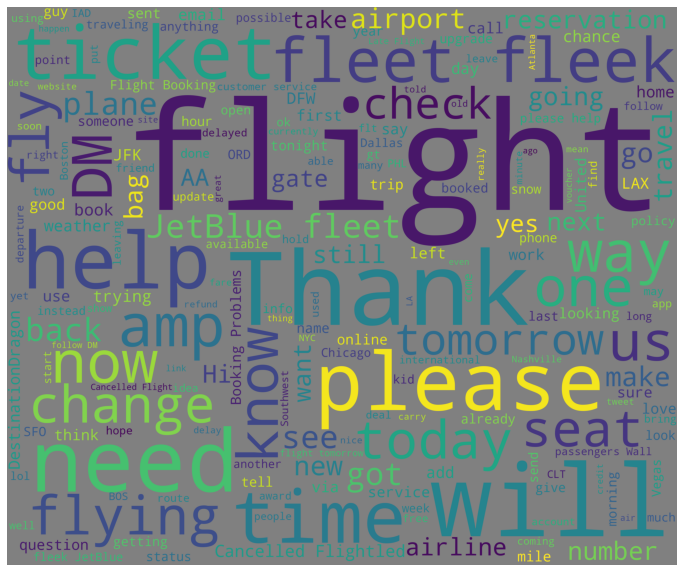

In [ ]:
#wordcloud Neutral Sentiment
new_df=df[df['airline_sentiment']=='neutral']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='gray',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

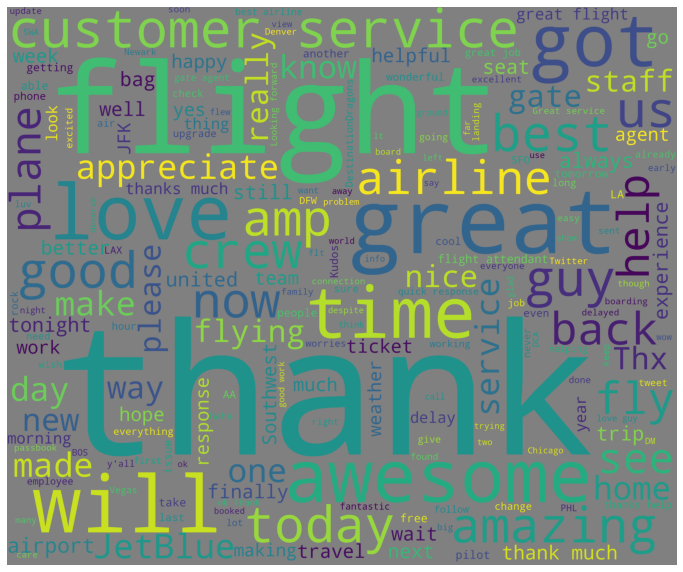

In [ ]:
#wordcloud Positive Sentiment
new_df=df[df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='gray',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


***WordCloud Observations (Before Pre-Processing)***

* Words that have significance to Negative tweets are largely Nouns or Adverbs. Time related theme seems significant. ("Hour", "Now", "Time")

* Words that have significance to Positive tweets are largely Adjectives or Verbs. ("Thank", "Awesome", "Amazing", "Love")

* The word "Flight" is prominent in all 3 classes. This will most likey contribute to errors, misclassifications and reduced model performance.

* The wordclouds show a few html character references such as the ampersand. These will be removed or replaced in the pre-processing steps below.




> ##### Class Analysis



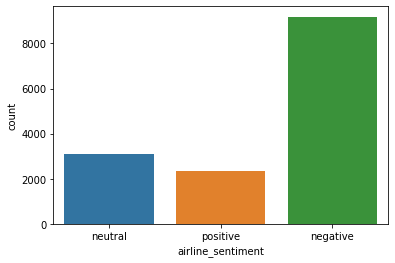

In [ ]:
sns.countplot(x="airline_sentiment", data=df);

In [ ]:
df.airline_sentiment.value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

```
This dataset is biased to the Negative Class. Only 16% of the records fall within the Positive class. 

```



> ##### a. Drop all other columns except “text” and “airline_sentiment”.



In [ ]:
df = df.sample(frac=1).reset_index(drop=True)  
df = df[['text', 'airline_sentiment']]



> ##### b. Check the shape of the data.



In [ ]:
df.shape

(14640, 2)



> #####  c. Print the first 5 rows of data.



In [ ]:
df.head(5)

,text,airline_sentiment
0,@united There is only one club at LAX - in te...,neutral
1,@JetBlue can't book a flight because of outdat...,negative
2,@SouthwestAir what is the status on flight#12...,neutral
3,"@united Very good flight, thank you!",positive
4,@AmericanAir and btwn gate a8 &amp; a15 I lost...,neutral


---
#### 3. Text pre-processing: Data preparation. ***(16 Marks)***
---





> #####    Emoticon conversion



In [ ]:
# replace emoticons with textual representation
# credit goes to : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Def"
}

In [ ]:
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

df['text'] = df['text'].apply(lambda x: convert_emoticons(x))



> ##### a. Html tag removal.



In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

df['text'] = df['text'].apply(lambda x: strip_html(x))



> #####   Remove HTTP



In [ ]:
def remove_http(text):
  text = re.sub(r"http\S+", "", text)
  return text
df['text'] = df['text'].apply(lambda x: remove_http(x))



>   Replace Contractions



In [ ]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

df['text'] = df['text'].apply(lambda x: replace_contractions(x))



> ##### b. Tokenization.



In [ ]:
# instantiate tokenizer class
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

In [ ]:
df['text'] = df.apply(lambda row: tokenizer.tokenize(row['text']), axis=1) # Tokenization of data

In [ ]:
df.head()

,text,airline_sentiment
0,"[there, is, only, one, club, at, lax, -, in, t...",neutral
1,"[cannot, book, a, flight, because, of, outdate...",negative
2,"[what, is, the, status, on, flight, #122, stl-...",neutral
3,"[very, good, flight, ,, thank, you, !]",positive
4,"[and, btwn, gate, a8, &, a15, i, lost, a, diam...",neutral




> #####  c. Remove the numbers.



In [ ]:
def remove_numbers(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'\d+', '', word)
        new_words.append(new_word)
    return new_words



> ##### d. Removal of Special Characters and Punctuations.



In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [ ]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words

In [ ]:
def remove_special_characters(words):
    pattern = r'[^a-zA-z0-9\s]'
    new_words = []
    for word in words:
        new_word = re.sub(pattern, '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words



> ##### e. Removal of stopwords



In [ ]:
stopwords = stopwords.words('english')
customlist = ['not']

In [ ]:
stopwords = list(set(stopwords) - set(customlist)) 

In [ ]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        if word not in stopwords:
            new_words.append(word)        # Append processed words to new list.
    return new_words



> ##### f. Conversion to lowercase



In [ ]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words



> ##### g. Lemmatize or stemming.



In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words



> ##### h. Join the words in the list to convert back to text string in the data frame. (So that each row contains the data in text format.)



In [ ]:
def normalize(words):
    words = remove_numbers(words)
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = remove_special_characters(words)
    words = remove_stopwords(words)
    words = to_lowercase(words)
    words = lemmatize_list(words)


    return ' '.join(words)
df['text'] = df.apply(lambda row: normalize(row['text']), axis=1)



>  #####  i. Print the first 5 rows of data after pre-processing.



In [ ]:
df.head()

,text,airline_sentiment
0,one club lax terminal across gate,neutral
1,cannot book flight outdated force optin verify...,negative
2,status flight stlaus,neutral
3,good flight thank,positive
4,btwn gate lose diamond earring dayjustgotworse...,neutral


---
#### 4. Vectorization: ***(10 Marks)***
---

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['airline_sentiment'], test_size=0.2, stratify=df['airline_sentiment'], random_state=42)

```
We're applying the train/test split prior to vectorization in order to prevent data leakage.
```



> ##### a. Use CountVectorizer.



In [ ]:
c_vec = CountVectorizer(analyzer = "word", max_features=2000) 
data_features_cv = c_vec.fit_transform(X_train) #fit and transform Train
test_features_cv = c_vec.transform(X_test) #transform Test

data_features_cv = data_features_cv.toarray() 
test_features_cv = test_features_cv.toarray() 

In [ ]:
print("Train Set Shape:")
print(data_features_cv.shape)
print('')
print("Test Set Shape:")
print(test_features_cv.shape)
print('')
print(data_features_cv[0])

Train Set Shape:
(11712, 2000)

Test Set Shape:
(2928, 2000)

[0 0 0 ... 0 0 0]




> ##### b. Use Tfidf Vectorizer.



In [ ]:
tf_vec = TfidfVectorizer(analyzer = "word", max_features=2000)
data_features_tf = tf_vec.fit_transform(X_train) #fit and transform Train
test_features_tf = tf_vec.transform(X_test) #transform Test

data_features_tf = data_features_tf.toarray() 
test_features_tf = test_features_tf.toarray() 

In [ ]:
print("Train Set Shape:")
print(data_features_tf.shape)
print('')
print("Test Set Shape:")
print(test_features_tf.shape)
print('')
print(data_features_tf[0])

Train Set Shape:
(11712, 2000)

Test Set Shape:
(2928, 2000)

[0. 0. 0. ... 0. 0. 0.]


---
#### 5. Fit and evaluate the model using both types of vectorization. ***(6+6 Marks)***

---



>  ##### Random Forest using CountVectorizer.



In [ ]:
forest = RandomForestClassifier(n_estimators=1800, n_jobs=4, max_depth=250, min_samples_leaf=6, class_weight='balanced')
forest = forest.fit(data_features_cv,y_train)
train_acc = forest.score(data_features_cv, y_train)
test_acc = forest.score(test_features_cv, y_test)
result_cv =  forest.predict(test_features_cv)   
print("Train Accuracy:")
print(train_acc)
print("")
print("Test Accuracy:")
print(test_acc)

Train Accuracy:
0.7721140710382514

Test Accuracy:
0.7534153005464481


In [ ]:
print('Accuracy of Random Forest using CountVectorizer is '+str(test_acc))
print(classification_report(result_cv,y_test))

Accuracy of Random Forest using CountVectorizer is 0.7534153005464481
              precision    recall  f1-score   support

    negative       0.80      0.87      0.83      1684
     neutral       0.62      0.54      0.58       704
    positive       0.76      0.66      0.71       540

    accuracy                           0.75      2928
   macro avg       0.72      0.69      0.71      2928
weighted avg       0.75      0.75      0.75      2928



<Figure size 432x288 with 0 Axes>

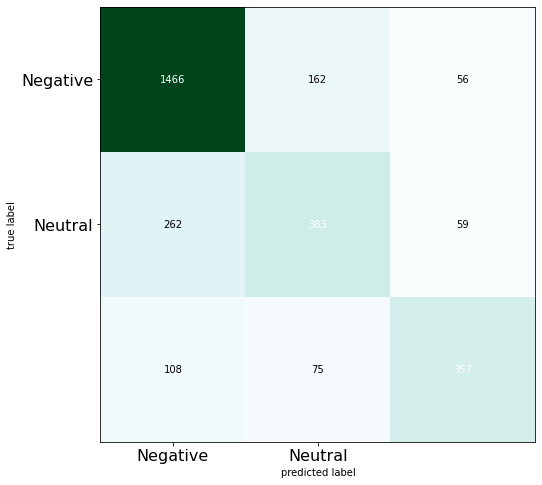

[[1466  162   56]
 [ 262  383   59]
 [ 108   75  357]]


In [ ]:
    cm=confusion_matrix(result_cv,y_test)
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.BuGn)
    plt.xticks(range(2), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
    plt.yticks(range(2), ['Negative', 'Neutral', 'Positive'], fontsize=16)
    plt.show()
    print(cm)

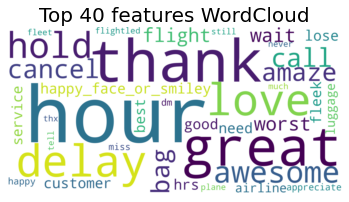

In [ ]:
all_features = c_vec.get_feature_names()            
top_features=''                                          
feat=forest.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=' '
    
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000,height=1000).generate(top_features)

plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()



> ##### Random Forest using TfidfVectorizer.



In [ ]:
forest = RandomForestClassifier(n_estimators=1800, n_jobs=4, max_depth=250, min_samples_leaf=6, class_weight='balanced')
forest = forest.fit(data_features_tf,y_train)
train_acc = forest.score(data_features_tf, y_train)
test_acc = forest.score(test_features_tf, y_test)
result_tf =  forest.predict(test_features_tf)  
print("Train Accuracy:")
print(train_acc)
print("")
print("Test Accuracy:")
print(test_acc)

Train Accuracy:
0.788422131147541

Test Accuracy:
0.7544398907103825


In [ ]:
print('Accuracy of Random Forest using Tfidf Vectorizer is '+str(test_acc))
print(classification_report(result_tf,y_test))

Accuracy of Random Forest using Tfidf Vectorizer is 0.7544398907103825
              precision    recall  f1-score   support

    negative       0.81      0.87      0.84      1699
     neutral       0.61      0.54      0.57       696
    positive       0.75      0.66      0.70       533

    accuracy                           0.75      2928
   macro avg       0.72      0.69      0.70      2928
weighted avg       0.75      0.75      0.75      2928



<Figure size 432x288 with 0 Axes>

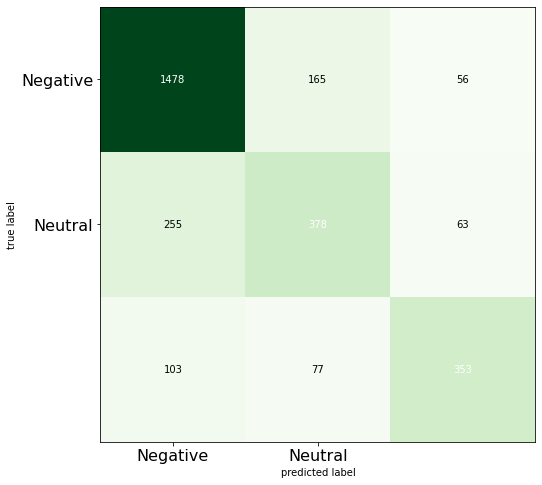

[[1478  165   56]
 [ 255  378   63]
 [ 103   77  353]]


In [ ]:
    cm=confusion_matrix(result_tf,y_test)
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Greens)
    plt.xticks(range(2), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
    plt.yticks(range(2), ['Negative', 'Neutral', 'Positive'], fontsize=16)
    plt.show()
    print(cm)

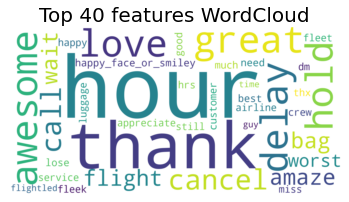

In [ ]:
all_features = tf_vec.get_feature_names()              
top_features=''                                            
feat=forest.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=' '
    
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000,height=1000).generate(top_features)

plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

---
#### 6. Summarize your understanding of the application of Various Pre-processing and Vectorization and the performance of your model on this dataset. ***(8 Marks)***
---



- We used a dataset which has **tweets in text format and their sentiment class rating - Negative, Neutral, Positive**
- We **created a Word Cloud plot** based on sentiment class rating. "Flight" was found to be a heavily weighted word in all 3 classes. This could have a negative effect on model performance.
- We found html character representaions in our text. These were removed with pre-processing.
- **Pre-processing** (cleaning and preparing text data) was performed for the purpose of reducing the text to only the words needed for the task of NLP sentiment analysis.
- We vectorized our data using both CountVectorizer and TF-IDF Vectorizer
- Machines cannot directly process text data in raw form. Vectorization breaks down the text into a numerical format that’s easily readable by the machine.
- **CountVectorizer** creates a "Bag of Words" - a representation of text that describes the occurrence of words within a document. Thus, transforming the text data into an array of integers.
- **TF-IDF Vectorizer** captures how important a word is to the document by calculating term frequency * inverse document frequency) - a scheme to weight individual tokens. Thus, transforming the text data into an array of floats.
- Random Forest Clasifier was used to generate the model for this dataset.
- The hyper parameters were determined by manual trial and error. The set of hyperparemters used in this notebook were selected because they provide the best combination of scoring while avoiding overfitting. In previous testing, higher training scores were obtained but the testing scores indicated overfitting. Those models were discarded and not presented in this notebook.
- K-fold CV was not used as I am trying to develop an intuition on the hyper parameter settings. 
- TF-IDF Vectorizer outperformed CountVectorizer. This is to be expected as TF-IDF takes into account the weight of the tokens. However, the improvement was less than expected and was only marginal - less than 1%.
- The Negative class outperformed both the Neutral and Postive classes. This is to be expected as 62% of the dataset belongs to the Negative class.
- In an attempt to mitigate the imbalance, we use the hyperparameter class_weight='balanced' in our Random Forest model.
- SMOTE upsampling was attempted in a previous version of this notebook. SMOTE caused overfitting, thus SMOTE was rejected and not included in this notebook.
- The word "Flight" was used heavily in all 3 classes. This had a negative impact on model performance.


---
Thoughts on improving model performance:
- We must a find a way to distinguish words used heavily in all the classes. Perahps N-Grams could improve model performance.
- Originally, the dataset contained 15 features. We dropped 13 features at the beginning of this notebook - only retaining the tweets and the target classes.
Perhaps some of the other features could be used in improving the training process. For example, there was a feature **"airline_sentiment_confidence"**. This feature indicated the strength of the confidence in the sentiment ratings.
What if we only trained on the rows with a high confidence - over 65%? If we only train on data where the confidence of the sentiment rating is high, would that improve our performance. Could training the model on rows with a low sentiment confidence dilute our model? Or, would this only cause overfitting?
Future tests with this method should be attempted to answer that question.
- In the end, we have a model with 75% accuracy and very little overfitting.



---



Pre-Processing Steps included:
- Emoticon conversion *(replace emoticon with text description)*
- Html tag removal
- Contraction Replacement *(hasn't to has not)*
- Tokenization *(separating text into smaller unit blocks for processing the raw text)*
- Number removal
- Special Characters and Punctuation removal
- Stopword removal *(common words with little or no inferential value)*
- Conversion to lowercase
- Lemmatization *(reducing different forms of a word to its dictionary or canonical root)*



---

Vectorization Steps included:
- CountVectorizer
- TF-IDF Vectorizer



---
#### 7.Overall notebook should have:***(4 Marks)***
---





> #####  a. Well commented code




This notebook provides clear and concise comments using the following 3 methods:

- commented out text within the code input cells. 
- comments entered as section headings.
- comments below the code input cells
- comments included as descriptions in the cell outputs
- comments as desciption in chart titles

The method used for each cell or section was determined by the appropriatness of the method for the process that is being described.



> ##### b. Structure and flow




The structure and flow of this notebook is in compliance with the instructions provided in the Project Statement found on the Olympus portal.